In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## ANN Regression Model ##

We would like to build a neural net that can predict the charges made to insurance companies by various customers. We will have data like age, sex, BMI, the number of children they have, whether they are a smoker, and which region of the USA they are from.

In [ ]:
# load the data
insurance_df = pd.read_csv('https://raw.githubusercontent.com/ammishra08/MachineLearning/master/Datasets/insurance.csv')
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


**EDA**

In [ ]:
# Let's get an idea of the type of data we have
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
# From this, we can see there are no null values
insurance_df.isnull().sum().sum()

0

We can see the different data types we have

* age - discrete + numeric
* sex - categorical
* bmi - continuous
* children - categorical
* smoker - categorical
* region - categorical
* charges - continuous

In [ ]:
# What are the unique values
print(f'unique sex: {insurance_df["sex"].unique()}')
print(f'unique children: {insurance_df["children"].unique()}')
print(f'unique smoker: {insurance_df["smoker"].unique()}')
print(f'unique regiom: {insurance_df["region"].unique()}')

unique sex: ['female' 'male']
unique children: [0 1 3 2 5 4]
unique smoker: ['yes' 'no']
unique regiom: ['southwest' 'southeast' 'northwest' 'northeast']


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


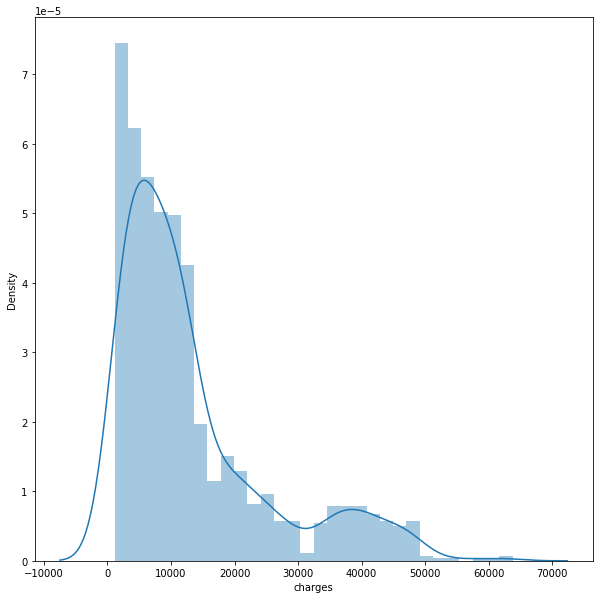

In [ ]:
# Let's check if the y-values (i.e. the charges) are normally distributed
plt.figure(figsize= (10,10))
sns.distplot(insurance_df['charges'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


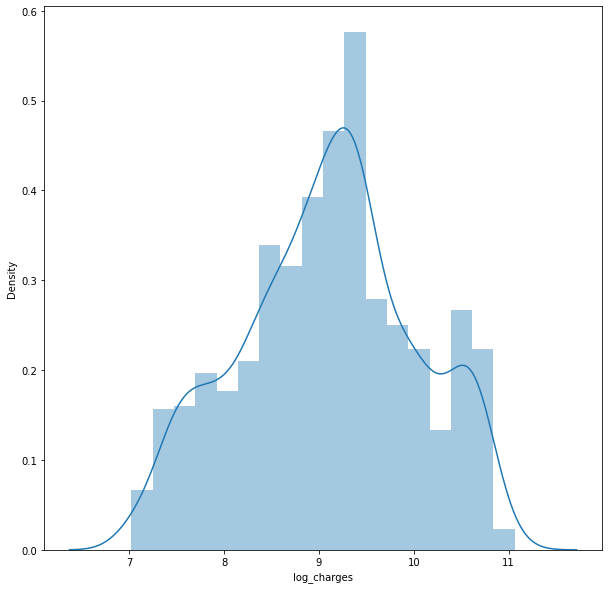

In [ ]:
# This looks heavily positively skewed
# This may make our regression less accurate
# Maybe we can transform it to make it look more normal
insurance_df['log_charges'] = np.log(insurance_df['charges'])

plt.figure(figsize= (10,10))
sns.distplot(insurance_df['log_charges'])
plt.show()

In [ ]:
# This already looks significantly better so we will work with this data set for now

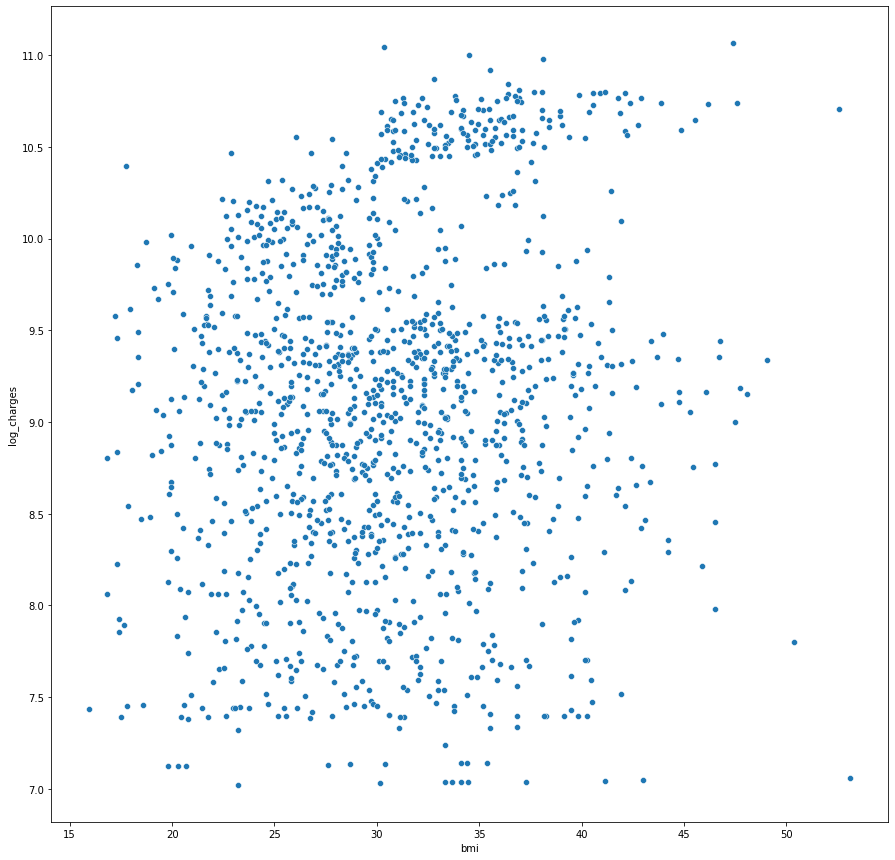

In [ ]:
# Let us see how the charges can be affected by the different categories
# bmi:
plt.figure(figsize=(15,15))
sns.scatterplot(x = 'bmi',
                y = 'log_charges',
                data = insurance_df)
plt.show()

In [ ]:
# There appears to be little correlation
insurance_df[['bmi','log_charges']].corr()
# < 0.15 so we can say that it has little affect on the outcome 
# May want to drop to allow for better convergence of the model

,bmi,log_charges
bmi,1.000000,0.132669
log_charges,0.132669,1.000000


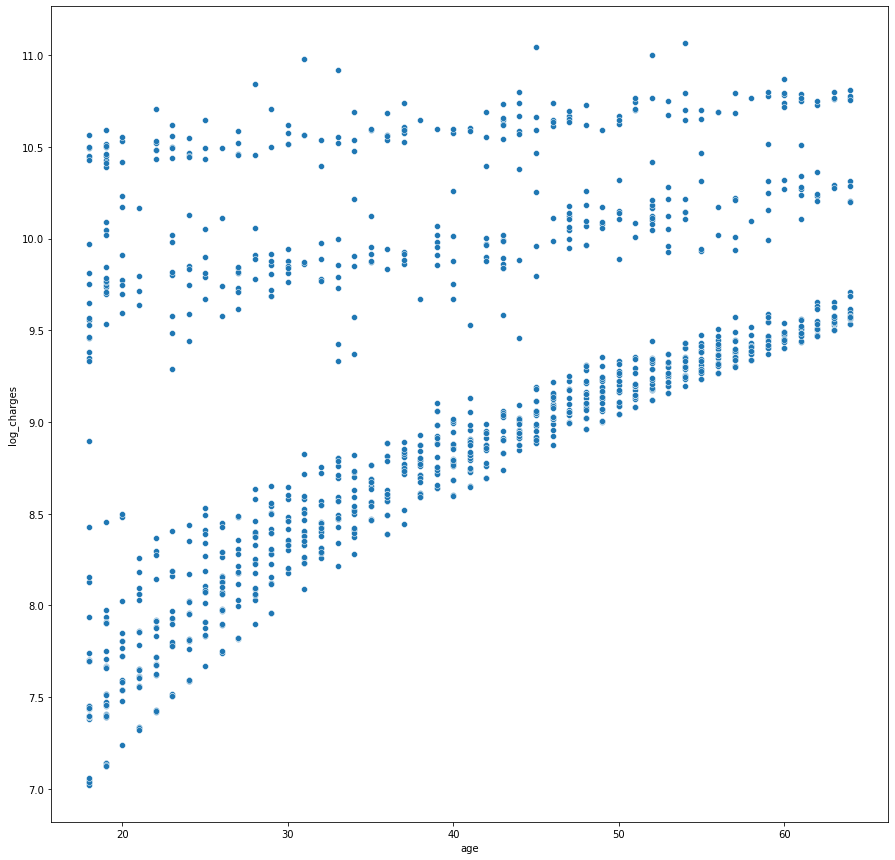

In [ ]:
# age
plt.figure(figsize=(15,15))
sns.scatterplot(x = 'age',
                y = 'log_charges',
                data = insurance_df)
plt.show()

In [ ]:
# This appears to be much more strongly correlated
insurance_df[['age','log_charges']].corr()
# There is a correlation ~0.5 but not strong enough for colinearity

,age,log_charges
age,1.000000,0.527834
log_charges,0.527834,1.000000


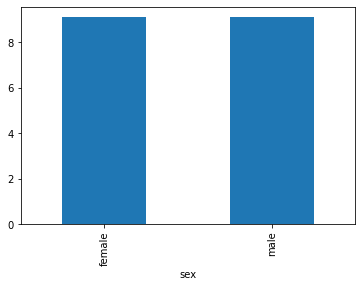

In [ ]:
# Now let's check with the categories
# sex
insurance_df.groupby('sex')['log_charges'].mean().plot.bar()
# These are almost identical

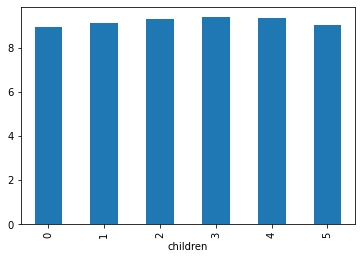

In [ ]:
# children
insurance_df.groupby('children')['log_charges'].mean().plot.bar()
# Again, these are very similar
# Any differences will be magnified by exp though

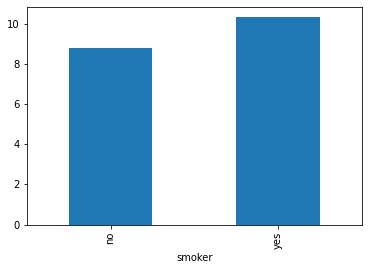

In [ ]:
# smoker
insurance_df.groupby('smoker')['log_charges'].mean().plot.bar()
# There is a big difference in charges here

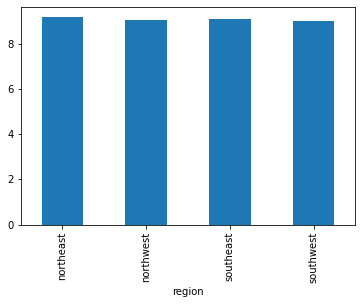

In [ ]:
# region
insurance_df.groupby('region')['log_charges'].mean().plot.bar()
# small difference in charges

**Removing outliers**

We need to check if the data has any outliers

In [ ]:
# We will just drop outliers

for feature in ['age','bmi','log_charges']:
  q1, q3 = np.percentile(insurance_df[feature], [25,75])
  IQR = q3-q1
  min = q1 - 1.5*IQR
  max = q3 + 1.5*IQR
  insurance_df.loc[insurance_df.loc[:,feature] < min, feature] = np.nan
  insurance_df.loc[insurance_df.loc[:,feature] > max, feature] = np.nan

insurance_df.isnull().sum()

age            0
sex            0
bmi            9
children       0
smoker         0
region         0
charges        0
log_charges    0
dtype: int64

In [ ]:
insurance_df.dropna(inplace=True)

In [ ]:
# We need to change some data types back to int
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1329 non-null   float64
 1   sex          1329 non-null   object 
 2   bmi          1329 non-null   float64
 3   children     1329 non-null   int64  
 4   smoker       1329 non-null   object 
 5   region       1329 non-null   object 
 6   charges      1329 non-null   float64
 7   log_charges  1329 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 93.4+ KB


In [ ]:
insurance_df['age'] = insurance_df['age'].astype(int)
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1329 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1329 non-null   int64  
 1   sex          1329 non-null   object 
 2   bmi          1329 non-null   float64
 3   children     1329 non-null   int64  
 4   smoker       1329 non-null   object 
 5   region       1329 non-null   object 
 6   charges      1329 non-null   float64
 7   log_charges  1329 non-null   float64
dtypes: float64(3), int64(2), object(3)
memory usage: 93.4+ KB


**Feature Engineering**

In [ ]:
# Want to move data into a binary format
sex = pd.get_dummies(insurance_df['sex'])
children = pd.get_dummies(insurance_df['children'], prefix = 'children')
smoker = pd.get_dummies(insurance_df['smoker'], prefix = 'smoker')
region = pd.get_dummies(insurance_df['region'])

insurance_df_engineered = pd.concat([insurance_df, sex, children, smoker, region], axis = 1)

In [ ]:
insurance_df_engineered

,age,sex,bmi,children,smoker,region,charges,log_charges,female,male,children_0,children_1,children_2,children_3,children_4,children_5,smoker_no,smoker_yes,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,9.734176,1,0,1,0,0,0,0,0,0,1,0,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,7.453302,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,8.400538,0,1,0,0,0,1,0,0,1,0,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,9.998092,0,1,1,0,0,0,0,0,1,0,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,8.260197,0,1,1,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,9.268661,0,1,0,0,0,1,0,0,1,0,0,1,0,0
1334,18,female,31.920,0,no,northeast,2205.98080,7.698927,1,0,1,0,0,0,0,0,1,0,1,0,0,0
1335,18,female,36.850,0,no,southeast,1629.83350,7.396233,1,0,1,0,0,0,0,0,1,0,0,0,1,0
1336,21,female,25.800,0,no,southwest,2007.94500,7.604867,1,0,1,0,0,0,0,0,1,0,0,0,0,1


In [ ]:
# Split into features and outcome
Y = insurance_df_engineered['log_charges']
X = insurance_df_engineered.drop(['sex','bmi','children','smoker','region','charges','log_charges'],axis = 1)

In [ ]:
# We also need to normalise our data to be within 0-1
# We can so this using sklearn package
# I have bookmarked the documentation
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled

array([[0.02173913, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2173913 , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.06521739, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.93478261, 1.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

**Split into train and test data**

In [ ]:
from sklearn.model_selection import train_test_split
# The train data will be 80%
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size = 0.2, random_state = 0)

**ANN Regression**

In [ ]:
# We can build a dense layer in the NN
# We need further imports
from keras.layers import Dense
from keras.models import Sequential # RNNs + RBMs are not sequential
from keras.optimizers import RMSprop

In [ ]:
# define a function to build NN
def build_model(input_size, *args,rate=0.001):
  model = Sequential()
  layers = iter(args)

  # Input layer
  model.add(Dense(units = next(layers),
                  activation = 'relu',
                  input_shape = [input_size]))
  
  # Hidden layers
  for layer in layers:
    model.add(Dense(units = layer,
                    activation = 'relu'))
    
  # Output layer
  model.add(Dense(units = 1))   # default activation is linear

  # Define optimizer
  new_optimizer = RMSprop(learning_rate = rate)

  # Compile NN
  model.compile(loss = 'mean_squared_error',
                optimizer = new_optimizer,
                metrics = ['mean_squared_error'])
  
  return model

In [ ]:
model_1 = build_model(len(X_train[0]),32,32)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                512       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_1.fit(X_train,Y_train,epochs=400, batch_size = 40,validation_data = (X_test,Y_test))

Epoch 1/400
27/27 [==============================] - 0s 7ms/step - loss: 68.7597 - mean_squared_error: 68.7597 - val_loss: 58.1684 - val_mean_squared_error: 58.1684
Epoch 2/400
27/27 [==============================] - 0s 2ms/step - loss: 41.8029 - mean_squared_error: 41.8029 - val_loss: 28.1849 - val_mean_squared_error: 28.1849
Epoch 3/400
27/27 [==============================] - 0s 2ms/step - loss: 14.4440 - mean_squared_error: 14.4440 - val_loss: 5.7018 - val_mean_squared_error: 5.7018
Epoch 4/400
27/27 [==============================] - 0s 2ms/step - loss: 2.3044 - mean_squared_error: 2.3044 - val_loss: 1.3706 - val_mean_squared_error: 1.3706
Epoch 5/400
27/27 [==============================] - 0s 2ms/step - loss: 0.7816 - mean_squared_error: 0.7816 - val_loss: 0.5532 - val_mean_squared_error: 0.5532
Epoch 6/400
27/27 [==============================] - 0s 2ms/step - loss: 0.3358 - mean_squared_error: 0.3358 - val_loss: 0.3434 - val_mean_squared_error: 0.3434
Epoch 7/400
27/27 [=====

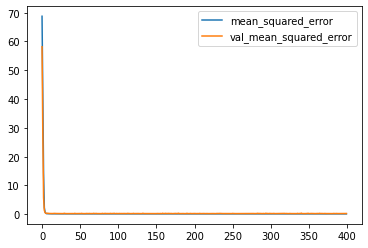

In [ ]:
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()
# The model converges pretty quickly

In [ ]:
# We can visually see how our NN does against the test data by looking at the predicated values
Y_log_predict = model_1.predict(X_test)
Y_predict = np.exp(Y_log_predict)
Y_predict = pd.Series(Y_predict.reshape(1,-1)[0])

In [ ]:
pd.concat([np.exp(Y_test).reset_index(),Y_predict], axis = 1)

,index,log_charges,0
0,1295,1964.78000,1902.890503
1,448,5910.94400,5665.994141
2,461,22144.03200,24748.353516
3,252,44260.74990,35583.050781
4,1259,10197.77220,10034.899414
...,...,...,...
261,467,12643.37780,13505.583984
262,803,38792.68560,22182.904297
263,617,23306.54700,36762.398438
264,195,1639.56310,1352.196411


In [ ]:
# While we see that it is not quite exactly right, we get a pretty good prediction
# We can do the r2 score to see how good it is


# We can use the r2_score to check how accurate the model is (accuracy score)
from sklearn.metrics import r2_score
r2_score(Y_test, Y_log_predict)

0.6708520367117271

**Changing the architecture**

In [ ]:
# Check if different NN gets better results
model_2 = build_model(len(X_train[0]), 64, 64, 64)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_2.fit(X_train,Y_train,epochs= 1000, batch_size = 40,validation_data = (X_test,Y_test))

Epoch 1/1000
27/27 [==============================] - 0s 6ms/step - loss: 28.4200 - mean_squared_error: 28.4200 - val_loss: 2.3707 - val_mean_squared_error: 2.3707
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.2728 - mean_squared_error: 1.2728 - val_loss: 0.5658 - val_mean_squared_error: 0.5658
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.3278 - mean_squared_error: 0.3278 - val_loss: 0.3636 - val_mean_squared_error: 0.3636
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.2657 - mean_squared_error: 0.2657 - val_loss: 0.2755 - val_mean_squared_error: 0.2755
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.2790 - mean_squared_error: 0.2790 - val_loss: 0.2552 - val_mean_squared_error: 0.2552
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.2487 - mean_squared_error: 0.2487 - val_loss: 0.3521 - val_mean_squared_error: 0.3521
Epoch 7/1000
27/27 [======

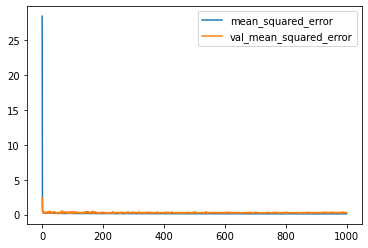

In [ ]:
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()
# We can see that we are getting a significantly higher loss for validation than training
# This suggests over fitting

In [ ]:
Y_log_predict = model_2.predict(X_test)
# We can use the r2_score to check how accurate the model is (accuracy score)
r2_score(Y_test, Y_log_predict)

0.6012899222738223

**Changing the architecture 2**

Epoch 1/1000
27/27 [==============================] - 0s 6ms/step - loss: 53.9799 - mean_squared_error: 53.9799 - val_loss: 25.8928 - val_mean_squared_error: 25.8928
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 9.5602 - mean_squared_error: 9.5602 - val_loss: 2.7852 - val_mean_squared_error: 2.7852
Epoch 3/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.8072 - mean_squared_error: 1.8072 - val_loss: 0.9966 - val_mean_squared_error: 0.9966
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.6255 - mean_squared_error: 0.6255 - val_loss: 0.4855 - val_mean_squared_error: 0.4855
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.2946 - mean_squared_error: 0.2946 - val_loss: 0.3487 - val_mean_squared_error: 0.3487
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.2411 - mean_squared_error: 0.2411 - val_loss: 0.3048 - val_mean_squared_error: 0.3048
Epoch 7/1000
27/27 [====

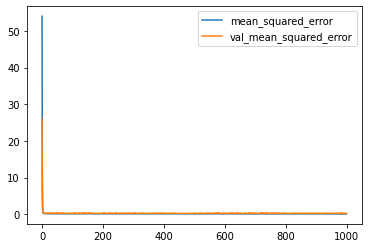

In [ ]:
# Let's see if there is a sweet spot
model_3 = build_model(len(X_train[0]), 32, 32, 32)
history = model_3.fit(X_train,Y_train,epochs= 1000, batch_size = 40,validation_data = (X_test,Y_test))
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()

In [ ]:
Y_log_predict = model_3.predict(X_test)
# We can use the r2_score to check how accurate the model is (accuracy score)
r2_score(Y_test, Y_log_predict)

0.6535123498157261

**Check - Reintroducing BMI**

It appears as if the first model was the most accurate with an r2 score of ~0.7

We already removed BMI as a feature since it was weakly correlated with charge. We can reintroduce it to see if our model performs any better

In [ ]:
x = insurance_df_engineered.drop(['sex','children','smoker','region','charges','log_charges'],axis = 1)

scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(x)
x_scaled = scaler.transform(x)
x_scaled

# The train data will be 80%
x_train, x_test, Y_train, Y_test = train_test_split(x_scaled, Y, test_size = 0.2, random_state = 0)

Epoch 1/400
27/27 [==============================] - 0s 6ms/step - loss: 77.0609 - mean_squared_error: 77.0609 - val_loss: 67.8879 - val_mean_squared_error: 67.8879
Epoch 2/400
27/27 [==============================] - 0s 2ms/step - loss: 52.2757 - mean_squared_error: 52.2757 - val_loss: 39.5796 - val_mean_squared_error: 39.5796
Epoch 3/400
27/27 [==============================] - 0s 2ms/step - loss: 23.7560 - mean_squared_error: 23.7560 - val_loss: 11.8796 - val_mean_squared_error: 11.8796
Epoch 4/400
27/27 [==============================] - 0s 2ms/step - loss: 4.4942 - mean_squared_error: 4.4942 - val_loss: 1.3254 - val_mean_squared_error: 1.3254
Epoch 5/400
27/27 [==============================] - 0s 2ms/step - loss: 0.8736 - mean_squared_error: 0.8736 - val_loss: 0.6093 - val_mean_squared_error: 0.6093
Epoch 6/400
27/27 [==============================] - 0s 2ms/step - loss: 0.4629 - mean_squared_error: 0.4629 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoch 7/400
27/27 [===

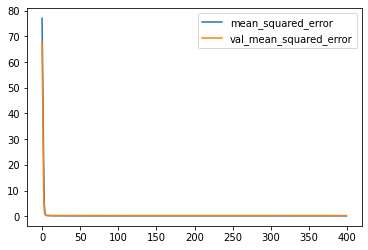

In [ ]:
model_4 = build_model(len(x_train[0]),32,32)
history = model_4.fit(x_train,Y_train,epochs= 400, batch_size = 40,validation_data = (x_test,Y_test))
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()

In [ ]:
Y_log_predict = model_4.predict(x_test)
# We can use the r2_score to check how accurate the model is (accuracy score)
r2_score(Y_test, Y_log_predict)

0.7370979045681224

**Changing architecture again**

We see we get a slight improvement with the bmi included. Let's see if we can improve on this

Epoch 1/600
27/27 [==============================] - 0s 6ms/step - loss: 63.3068 - mean_squared_error: 63.3068 - val_loss: 37.7588 - val_mean_squared_error: 37.7588
Epoch 2/600
27/27 [==============================] - 0s 2ms/step - loss: 16.0076 - mean_squared_error: 16.0076 - val_loss: 2.7687 - val_mean_squared_error: 2.7687
Epoch 3/600
27/27 [==============================] - 0s 2ms/step - loss: 1.2605 - mean_squared_error: 1.2605 - val_loss: 0.6607 - val_mean_squared_error: 0.6607
Epoch 4/600
27/27 [==============================] - 0s 2ms/step - loss: 0.4196 - mean_squared_error: 0.4196 - val_loss: 0.3812 - val_mean_squared_error: 0.3812
Epoch 5/600
27/27 [==============================] - 0s 2ms/step - loss: 0.2384 - mean_squared_error: 0.2384 - val_loss: 0.3398 - val_mean_squared_error: 0.3398
Epoch 6/600
27/27 [==============================] - 0s 2ms/step - loss: 0.2209 - mean_squared_error: 0.2209 - val_loss: 0.3157 - val_mean_squared_error: 0.3157
Epoch 7/600
27/27 [=========

0.5862070583684627

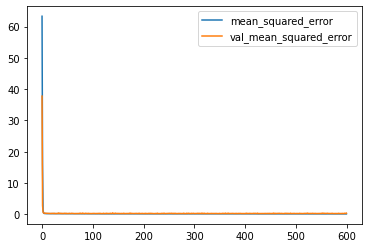

In [ ]:
model_5 = build_model(len(x_train[0]),64,64)
history = model_5.fit(x_train,Y_train,epochs= 600, batch_size = 40,validation_data = (x_test,Y_test))
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()

Y_log_predict = model_5.predict(x_test)
# We can use the r2_score to check how accurate the model is (accuracy score)
r2_score(Y_test, Y_log_predict)

# Again we find this model performs the worst

**Non-normally distributed target**

We took the target to be log_charges because that fit a normal distribution better. Can we improve the model by taking the target to just be charges where the affect of each of the categories is more pronounced

Epoch 1/400
27/27 [==============================] - 0s 6ms/step - loss: 299985600.0000 - mean_squared_error: 299985600.0000 - val_loss: 391840928.0000 - val_mean_squared_error: 391840928.0000
Epoch 2/400
27/27 [==============================] - 0s 2ms/step - loss: 299943040.0000 - mean_squared_error: 299943040.0000 - val_loss: 391780672.0000 - val_mean_squared_error: 391780672.0000
Epoch 3/400
27/27 [==============================] - 0s 2ms/step - loss: 299880960.0000 - mean_squared_error: 299880960.0000 - val_loss: 391689056.0000 - val_mean_squared_error: 391689056.0000
Epoch 4/400
27/27 [==============================] - 0s 2ms/step - loss: 299786112.0000 - mean_squared_error: 299786112.0000 - val_loss: 391551744.0000 - val_mean_squared_error: 391551744.0000
Epoch 5/400
27/27 [==============================] - 0s 2ms/step - loss: 299648128.0000 - mean_squared_error: 299648128.0000 - val_loss: 391358560.0000 - val_mean_squared_error: 391358560.0000
Epoch 6/400
27/27 [================

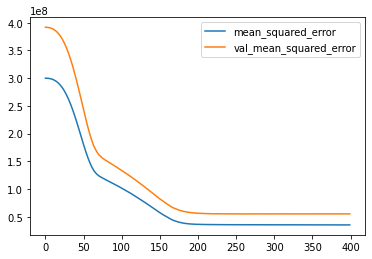

The r2_score is: 0.6757228061799636


In [ ]:
y = insurance_df_engineered['charges']

# The train data will be 80%
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 0)

model_6 = build_model(len(X_train[0]),32,32)
history = model_6.fit(X_train,y_train,epochs= 400, batch_size = 40,validation_data = (X_test,y_test))
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()
plt.show()

y_log_predict = model_6.predict(X_test)
# We can use the r2_score to check how accurate the model is (accuracy score)
print(f'The r2_score is: {r2_score(y_test, y_log_predict)}')

**Changing the architecture - final time**

We see that this did not improve the performance of the model

There is a large gap between training and validation error so we may be overfitting the data. Let's see if a smaller NN helps

Epoch 1/400
27/27 [==============================] - 0s 6ms/step - loss: 299985792.0000 - mean_squared_error: 299985792.0000 - val_loss: 391851456.0000 - val_mean_squared_error: 391851456.0000
Epoch 2/400
27/27 [==============================] - 0s 2ms/step - loss: 299959808.0000 - mean_squared_error: 299959808.0000 - val_loss: 391815648.0000 - val_mean_squared_error: 391815648.0000
Epoch 3/400
27/27 [==============================] - 0s 2ms/step - loss: 299924480.0000 - mean_squared_error: 299924480.0000 - val_loss: 391767520.0000 - val_mean_squared_error: 391767520.0000
Epoch 4/400
27/27 [==============================] - 0s 2ms/step - loss: 299877856.0000 - mean_squared_error: 299877856.0000 - val_loss: 391704992.0000 - val_mean_squared_error: 391704992.0000
Epoch 5/400
27/27 [==============================] - 0s 2ms/step - loss: 299816512.0000 - mean_squared_error: 299816512.0000 - val_loss: 391623424.0000 - val_mean_squared_error: 391623424.0000
Epoch 6/400
27/27 [================

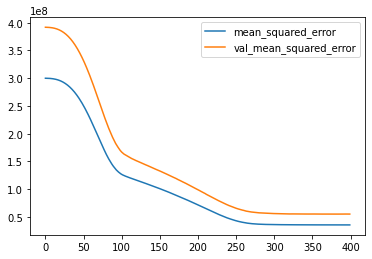

The r2_score is: 0.6758702396651746


In [ ]:
model_7 = build_model(len(X_train[0]),16,16)
history = model_7.fit(X_train,y_train,epochs= 400, batch_size = 40,validation_data = (X_test,y_test))
pd.DataFrame(history.history)[['mean_squared_error','val_mean_squared_error']].plot()
plt.show()

y_log_predict = model_7.predict(X_test)
# We can use the r2_score to check how accurate the model is (accuracy score)
print(f'The r2_score is: {r2_score(y_test, y_log_predict)}')

In [ ]:
# We do not get an improvement on the previous models

**Evaluation**

We have seen that the best model we produced was model_4. This had 2 hidden layers with 32 nodes in each. The r2_score was around

r2_score ~ 0.74

Here we used the log_charge because that gave a more normally distributed target which is part of the assumptions in regression. We also kept the BMI in even though it was weekly correlated with charge. This suggests that the AI can learn something from even weak correlation.